## Interval Analysis

In [2]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=-1) # added softmax for probabilities
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()


Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [4]:
def train_model(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}')

def test_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy on images: {100 * correct / total}')

In [8]:
train_model(model, 15)
test_model(model)

Epoch 1/15, Loss: 1.538
Epoch 2/15, Loss: 1.536
Epoch 3/15, Loss: 1.535
Epoch 4/15, Loss: 1.533
Epoch 5/15, Loss: 1.531
Epoch 6/15, Loss: 1.530
Epoch 7/15, Loss: 1.529
Epoch 8/15, Loss: 1.527
Epoch 9/15, Loss: 1.526
Epoch 10/15, Loss: 1.525
Epoch 11/15, Loss: 1.524
Epoch 12/15, Loss: 1.522
Epoch 13/15, Loss: 1.521
Epoch 14/15, Loss: 1.520
Epoch 15/15, Loss: 1.519
Accuracy on images: 94.64


### Write the interval analysis for the simple model

In [11]:
## TODO: Write the interval analysis for the simple model
## you can use https://github.com/Zinoex/bound_propagation
from bound_propagation import BoundModelFactory, HyperRectangle
from bound_propagation.general import BoundModule
from bound_propagation.bounds import IntervalBounds, LinearBounds
    
from bound_propagation import BoundModelFactory, HyperRectangle

# Create a simple sequential model that bound_propagation can handle
# Note: No Flatten layer - we'll flatten the input manually
simple_model = nn.Sequential(
    nn.Linear(28*28, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

# Copy weights from the trained model
mu = 0.1307
sigma = 0.3081

# Suppose simple_model is the Sequential model we built
# simple_model[0] = nn.Linear(28*28, 200)

with torch.no_grad():
    W = model[1].fc.weight.clone()  # original trained weights
    b = model[1].fc.bias.clone()

    # Fold normalization into first layer
    W_new = W / sigma
    b_new = b - (W.sum(dim=1) * mu / sigma)

    simple_model[0].weight.copy_(W_new)
    simple_model[0].bias.copy_(b_new)

    # Copy second layer normally 
    simple_model[2].weight.copy_(model[1].fc2.weight)
    simple_model[2].bias.copy_(model[1].fc2.bias)

simple_model = simple_model.to(device)
simple_model.eval()

# Convert model to bound-propagation capable model
factory = BoundModelFactory()
bound_model = factory.build(simple_model)

def verify_with_boundprop(bound_model, test_loader, eps_list, device):
    bound_model.eval()
    verified_accs = []

    for eps in eps_list:
        total = 0
        verified = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)  # flatten manually

            # Create L∞ bounds
            input_bounds = HyperRectangle.from_eps(images, eps)

            # Interval Bound Propagation
            bounds = bound_model.ibp(input_bounds)
            lower, upper = bounds.lower, bounds.upper

            # Verification condition
            for i in range(images.size(0)):
                true = labels[i].item()
                l_i, u_i = lower[i], upper[i]

                if l_i[true] > u_i[torch.arange(10, device=device) != true].max():
                    verified += 1
                total += 1

        acc = 100.0 * verified / total
        verified_accs.append(acc)
        print(f"ε={eps:.3f} → Verified accuracy: {acc:.2f}%")

    return verified_accs

eps_list = np.linspace(0.01, 0.1, 10)
verified_accs = verify_with_boundprop(bound_model, test_loader, eps_list, device)


ε=0.010 → Verified accuracy: 12.56%
ε=0.020 → Verified accuracy: 0.14%
ε=0.030 → Verified accuracy: 0.00%
ε=0.040 → Verified accuracy: 0.00%
ε=0.050 → Verified accuracy: 0.00%
ε=0.060 → Verified accuracy: 0.00%
ε=0.070 → Verified accuracy: 0.00%
ε=0.080 → Verified accuracy: 0.00%
ε=0.090 → Verified accuracy: 0.00%
ε=0.100 → Verified accuracy: 0.00%


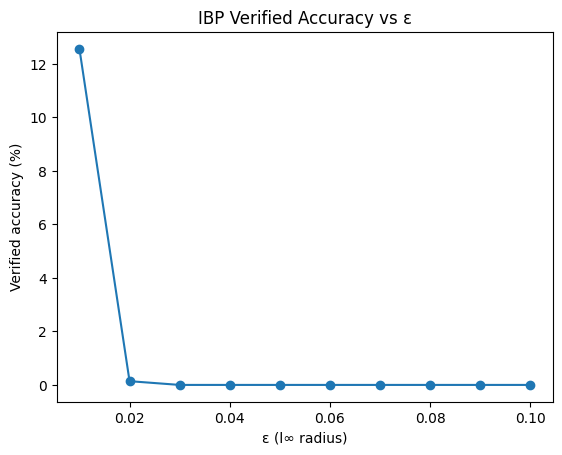

In [12]:
# Plot
import matplotlib.pyplot as plt
plt.plot(eps_list, verified_accs, marker="o")
plt.xlabel("ε (l∞ radius)")
plt.ylabel("Verified accuracy (%)")
plt.title("IBP Verified Accuracy vs ε")
plt.show()

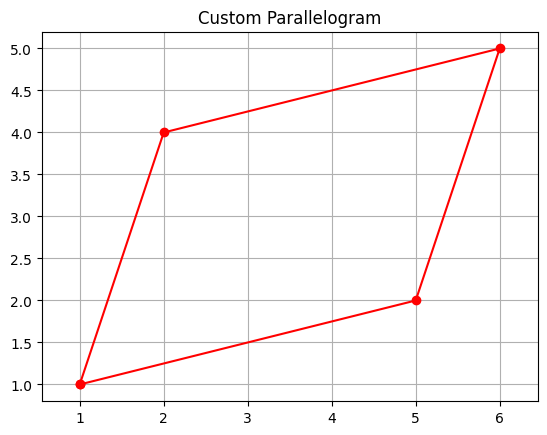

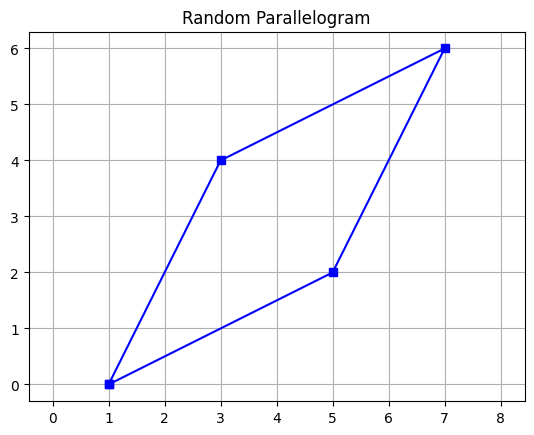

In [8]:
import matplotlib.pyplot as plt
import random

def generate_parallelogram(p1, p2, p3):
    """
    Generates the vertices of a parallelogram given three consecutive vertices.
    
    Args:
        p1 (tuple): The (x, y) coordinates of the first vertex.
        p2 (tuple): The (x, y) coordinates of the second vertex.
        p3 (tuple): The (x, y) coordinates of the third vertex.
        
    Returns:
        tuple: A tuple containing the (x, y) coordinates of all four vertices.
    """
    # Vector arithmetic to find the fourth vertex
    # p4 = p1 + (p3 - p2)
    p4 = (p1[0] + p3[0] - p2[0], p1[1] + p3[1] - p2[1])
    
    return [p1, p2, p3, p4, p1] # Return with p1 at the end to close the polygon

# --- Example 1: Generate a parallelogram with custom coordinates ---
p1_custom = (1, 1)
p2_custom = (5, 2)
p3_custom = (6, 5)
parallelogram_custom = generate_parallelogram(p1_custom, p2_custom, p3_custom)
x_custom, y_custom = zip(*parallelogram_custom)

plt.figure()
plt.plot(x_custom, y_custom, 'ro-') # 'ro-' creates red circles at vertices and a line
plt.title('Custom Parallelogram')
plt.grid(True)
plt.axis('equal') # Set axis to be equal for true shape representation
plt.show()

# --- Example 2: Generate a parallelogram with random coordinates ---
# Generate three random points
p1_random = (1,0)
p2_random = (3,4)
p3_random = (7,6)

parallelogram_random = generate_parallelogram(p1_random, p2_random, p3_random)
x_random, y_random = zip(*parallelogram_random)

plt.figure()
plt.plot(x_random, y_random, 'bs-') # 'bs-' creates blue squares at vertices and a line
plt.title('Random Parallelogram')
plt.grid(True)
plt.axis('equal')
plt.show()
